<a href="https://colab.research.google.com/github/jylin04/mi-ntk/blob/main/modular_arithmetic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup (run this and *'d cells at start)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import math

import numpy as np
import torch as t

from torch import nn, Tensor
from torch.nn import functional as F

from tqdm.notebook import tqdm

from typing import Tuple, Optional

In [3]:
import matplotlib.pyplot as plt

In [4]:
%pip install -q git+https://github.com/jylin04/mi-ntk.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [5]:
import ntk, ma

from ma import Quadratic, Scale, ModularArithmeticMLP
from ma import build_mod_arith_data, build_mod_arith_data_symbreak, train, test
from ntk import full_jacobian, class_jacobian, jacobian_by_layer, empirical_ntk, empirical_ntk_by_layer, LinearisedPredictor, eig_decompose
from ntk import axis_laplacians_pxp, two_stage_axis_diagonalization

In [6]:
# cfg
epochs: int = 5000
batch_size: int = 1024
lr: float = 1e-3
n_features: int = 80
n_hidden: int = 20
sparsity: float = 0.9
importance: float = 0.9

device = t.device("cuda" if t.cuda.is_available() else "cpu")
seed = 40

t.manual_seed(seed)

# 1. Reproduce grokking results

## Train the toy model*

In [7]:
# For this slightly smaller model than the one in Gromov, the eNTK fits in T4 GPU.

class HyperParams:
  p: int = 29
  width: int = 512
  #width: int = 64
  alpha: float = 0.7
  lr: float = 0.05
  epochs: int = 500
  eval_every: int = 200
  log_every: int = 10
  seed: int = 0

params = HyperParams()
t.manual_seed(params.seed)

device = t.device("cuda" if t.cuda.is_available() else "cpu")

In [8]:
# Train/test split
X, Y, y_idx, pairs = build_mod_arith_data(params.p, device=device)
#X, Y, y_idx, pairs = build_mod_arith_data_symbreak(params.p, device=device)

X_full = X
Y_full = Y

perm = t.randperm(X.shape[0], device=device)
n_train = int(X.shape[0] * params.alpha)          # Put this in manually: fraction of pairs in the training vs. test set.
idx_tr, idx_te = perm[:n_train], perm[n_train:]

x_train = X[idx_tr]
y_train = Y[idx_tr]

x_test = X[idx_te]
y_test = Y[idx_te]

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size = len(x_train), shuffle=True)
test_loader = DataLoader(TensorDataset(x_test, y_test), batch_size = len(x_test), shuffle = False)

In [10]:
model = ModularArithmeticMLP(p=params.p, n_hidden=params.width, device=device)
opt = t.optim.AdamW(model.parameters(), lr = params.lr)

In [11]:
tr_loss = []
te_loss = []
tr_acc = []
te_acc = []

for epoch in range(params.epochs):
    train_loss = train(model, train_loader, opt, device)
    #train_loss = train(model, train_loader, opt, device, loss_fn = F.cross_entropy)
    if epoch % params.log_every == 0:
        tr_loss.append(train_loss)
        te_loss.append(F.mse_loss(model(x_test), y_test).item())
        #te_loss.append(F.cross_entropy(model(x_test), y_test).item())
        acc = test(model, test_loader, device)
        tr_acc.append(test(model, train_loader, device))
        te_acc.append(acc)
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}")

Epoch 0: Train loss 0.0345, Accuracy 2.4
Epoch 10: Train loss 0.0331, Accuracy 1.2
Epoch 20: Train loss 0.0325, Accuracy 0.4
Epoch 30: Train loss 0.0315, Accuracy 0.4
Epoch 40: Train loss 0.0295, Accuracy 0.0
Epoch 50: Train loss 0.0256, Accuracy 0.0
Epoch 60: Train loss 0.0191, Accuracy 0.8
Epoch 70: Train loss 0.0110, Accuracy 6.7
Epoch 80: Train loss 0.0049, Accuracy 47.0
Epoch 90: Train loss 0.0022, Accuracy 82.2
Epoch 100: Train loss 0.0010, Accuracy 93.3
Epoch 110: Train loss 0.0005, Accuracy 96.8
Epoch 120: Train loss 0.0003, Accuracy 98.4
Epoch 130: Train loss 0.0001, Accuracy 100.0
Epoch 140: Train loss 0.0001, Accuracy 100.0
Epoch 150: Train loss 0.0001, Accuracy 100.0
Epoch 160: Train loss 0.0000, Accuracy 100.0
Epoch 170: Train loss 0.0000, Accuracy 100.0
Epoch 180: Train loss 0.0000, Accuracy 100.0
Epoch 190: Train loss 0.0000, Accuracy 100.0
Epoch 200: Train loss 0.0000, Accuracy 100.0
Epoch 210: Train loss 0.0000, Accuracy 100.0
Epoch 220: Train loss 0.0000, Accuracy 100

In [12]:
# Uncomment iff training w/ cyclic encoding
'''for epoch in range(200):
    train_loss = train(model, train_loader, opt, device)
    if epoch % params.log_every == 0:
        tr_loss.append(train_loss)
        te_loss.append(F.mse_loss(model(x_test), y_test).item())
        acc = test(model, test_loader, device)
        tr_acc.append(test(model, train_loader, device))
        te_acc.append(acc)
        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}"'''

'for epoch in range(200):\n    train_loss = train(model, train_loader, opt, device)\n    if epoch % params.log_every == 0:\n        tr_loss.append(train_loss)\n        te_loss.append(F.mse_loss(model(x_test), y_test).item())\n        acc = test(model, test_loader, device)\n        tr_acc.append(test(model, train_loader, device))\n        te_acc.append(acc)\n        print(f"Epoch {epoch}: Train loss {train_loss:.4f}, Accuracy {acc:.1f}"'

## Plots and linear probes

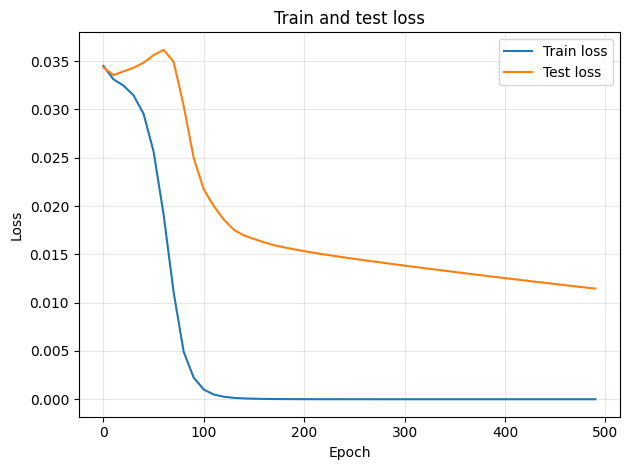

In [13]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_loss, label="Train loss")
plt.plot(x_axis, te_loss, label="Test loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

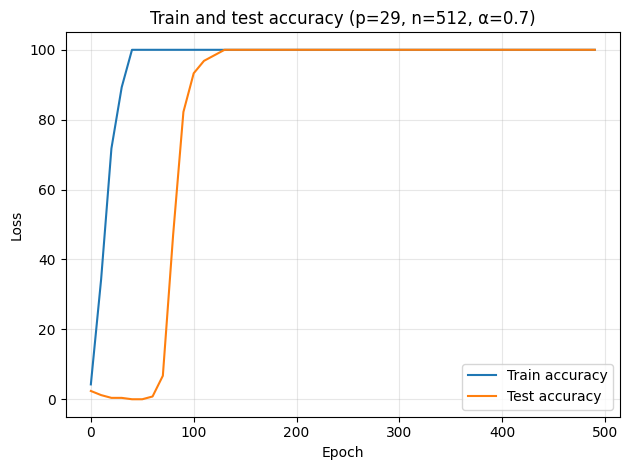

In [13]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_acc, label="Train accuracy")
plt.plot(x_axis, te_acc, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test accuracy (p=29, n=512, α=0.7)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
<>:16: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-634976628.py:16: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')
/tmp/ipython-input-634976628.py:16: SyntaxWarning: invalid escape sequence '\i'
  plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')


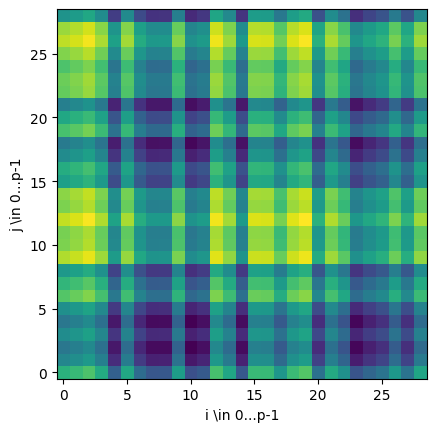

In [14]:
# Preactivation of a first-layer neuron over a grid of all possible inputs
p= params.p

digits = t.cartesian_prod(t.arange(p, device=device), t.arange(p, device=device))

x_left = F.one_hot(digits[:,0], num_classes=p).float()
x_right = F.one_hot(digits[:,1], num_classes=p).float()
x = t.cat([x_left, x_right], dim=1)
h = (model.net[1](model.net[0](x)))

img = h[:,4].reshape(p,p).detach().cpu().numpy()                # transpose so (i,j) matches (x,y)
plt.figure()
plt.imshow(img, origin='lower',
           extent=[-0.5, p-0.5, -0.5, p-0.5], interpolation='none')
plt.gca().set_aspect('equal', 'box')
plt.xlabel('i \in 0...p-1'); plt.ylabel('j \in 0...p-1')
#plt.colorbar(label='value')
plt.show()

Yay, it works!

In [14]:
def get_acts_lbls(model: nn.Module, layer: nn.Module, loader: DataLoader, device: str ='cpu') -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Saves the model activations at the specified layer when we run the dataloader through the model, along with corresponding labels.

    model  : your trained nn.Module
    layer  : sub-module whose output you want (e.g. model.hidden)

    Returns:
    acts: (N, hidden_dim) float32 numpy array of model activations
    left: (N,) int32 numpy array
    right: (N,) int32 numpy array
    y_sum: (N,) int32 numpy array
    """
    model.eval().to(device)
    acts, y_sum, left, right = [], [], [], []

    h = layer.register_forward_hook(lambda _, __, out: acts.append(out.detach().cpu()))

    with t.no_grad():
        for xb, yb, d_pair in loader:                     # d_pair = (left, right)
            model(xb.to(device))
            y_sum.append(yb)                              # (d1+d2) % 10
            left.append(d_pair[:,0])                      # left-digit ID
            right.append(d_pair[:,1])                     # right-digit ID

    h.remove()
    return (t.cat(acts).detach().cpu().numpy(),
            t.argmax(t.cat(y_sum), dim=1).detach().cpu().numpy(),
            t.cat(left).detach().cpu().numpy(),
            t.cat(right).detach().cpu().numpy())

In [15]:
# Fresh data loader over the training set incl. labels.
probe_loader = DataLoader(
    TensorDataset(x_train, y_train, pairs[idx_tr]),  # include digit pairs
    batch_size = len(x_train),
    shuffle     = False)          # <--- important

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [17]:
# Next three cells: Train linear probe to predict left digit, right digit, sum of digits from activations.

train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[1], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 0.1054421768707483
left-digit probe acc: 1.0
right-digit probe acc: 1.0


In [18]:
train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[2], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 1.0
left-digit probe acc: 1.0
right-digit probe acc: 1.0


In [19]:
train_act, sum_train, left_train, right_train = get_acts_lbls(model, model.net[3], probe_loader)

#scaler = StandardScaler().fit(train_act)
#X = scaler.transform(train_act)

X = train_act

probe_sum  = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, sum_train)
probe_left = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, left_train)
probe_right = LogisticRegression(max_iter=10000, multi_class='multinomial').fit(X, right_train)

print("sum-digit probe acc :", accuracy_score(sum_train,  probe_sum.predict(X)))
print("left-digit probe acc:", accuracy_score(left_train, probe_left.predict(X)))
print("right-digit probe acc:", accuracy_score(right_train, probe_right.predict(X)))

sum-digit probe acc : 1.0
left-digit probe acc: 0.1921768707482993
right-digit probe acc: 0.18877551020408162


# 2. Interpret eNTK eigenvectors

## 2.1. Indicators*

Used to make heat maps; we'll take their inner product with NTK eigenvectors or the equivalent.

In [13]:
def build_indicators(labels: t.Tensor, p: int):
    """
    labels : (N, 2) int array
             labels[:,0] = left digit (0-9)
             labels[:,1] = right digit (0-9)

    returns dict of {name: (N,) binary indicator}
    and     dict of {name: (N,10) one-hot matrix}  # for left/right/sum
    """
    left  = labels[:, 0]
    right = labels[:, 1]
    N     = len(labels)

    # --- A. atomic digit identity -----------------------------------------
    onehot = lambda v: np.eye(p, dtype=bool)[v]          # (N,p)

    left_onehot   = onehot(left)                          # (N,p)
    right_onehot  = onehot(right)

    # --- B. task-direct indicators ----------------------------------------
    sum_modp     = (left + right) % p
    sum_onehot    = onehot(sum_modp)

    carry_bit     = (left + right) >= p                  # (N,)
    same_parity   = (left % 2) == (right % 2)            # (N,)

    # --- C. low-order structure ------------------------------------------
    left_parity   = (left  % 2 == 1)                      # (N,)
    right_parity  = (right % 2 == 1)                      # (N,)
    same_digit    = left == right                         # (N,)

    # --- package ----------------------------------------------------------
    binary = {
        'carry'        : carry_bit,
        'same_parity'  : same_parity,
        'left_parity'  : left_parity,
        'right_parity' : right_parity,
        'same_digit'   : same_digit,
    }
    onehots = {
        'left_digit'   : left_onehot,    # each column k → “left digit = k”
        'right_digit'  : right_onehot,
        'sum_digit'    : sum_onehot,
    }
    return binary, onehots

In [14]:
binary, onehots = build_indicators(pairs.cpu().numpy(), params.p)

In [15]:
def fourier_cols(vals: np.ndarray, p: int) -> np.ndarray:
  """
  Build [cos(2π k val/p), sin(2π k val/p)] stacked column-wise.
  Return float32 array (N, floor(p//2), 2).
  """
  v = vals % p
  cols = []
  for k in range(1, p//2+1):
    ang = 2 * np.pi * k * v / p
    cols.append(np.stack((np.cos(ang), np.sin(ang)), axis=-1))  # (N, 2)
  F = np.stack(cols, axis=1).astype(np.float32)  # (N, floor(p//2), 2)
  return F


def build_fourier_features(labels: np.ndarray, p: int):
  """
  labels: (N,2) int array
  p     : modulus (odd)

  Returns: dict of real Fourier features:
    'n', 'm', 'sum', 'diff', '2n', '2m': (N, floor(p//2), 2)
    'readout': (N, p, floor(p//2), 2)
  """
  feats: Dict[str, np.ndarray] = {}

  left = labels[:, 0]
  right = labels[:, 1]

  # --- First-layer preactivation features ---------------------------------
  feats['n'] = fourier_cols(left, p)              #(N, floor(p//2), 2)
  feats['m'] = fourier_cols(right,p)

  # --- First-layer activation features ------------------------------------
  sum_mod  = (left + right) % p
  diff_mod = (left - right) % p
  feats['sum'] = fourier_cols(sum_mod, p)
  feats['diff'] = fourier_cols(diff_mod, p)
  feats['2n'] = fourier_cols(2 * left, p)
  feats['2m'] = fourier_cols(2 * right, p)

  # --- Second-layer preactivation features --------------------------------
  R = np.empty((labels.shape[0], p, p//2, 2))
  for q in range(p):
    R[:, q, :, :] = fourier_cols((sum_mod - q), p)
  feats['readout'] = R

  return feats

In [16]:
feats = build_fourier_features(pairs.cpu().numpy(), params.p)

## 2.2 Kernel and disentanglement algorithm.

### 2.2.1. Kernels*

In [17]:
# Dictionary of per-layer eNTK's

entk = empirical_ntk_by_layer(model.to(device), t.Tensor(X_full).to(device), t.Tensor(X_full).to(device))

In [18]:
print(*entk)

net.0 net.3


In [21]:
# For our toy model there are two per-layer eNTK's, we can store them like so. Each shape (N,N,C,C)

entk_0 = entk['net.0']
entk_3 = entk['net.3']

In [19]:
# Also we can compute the full eNTK by summing them if we want.
vals = list(entk.values())
entk_full = t.zeros_like(vals[0])
for K in vals:
  entk_full += K

### 2.2.2. Eigendecomposition *

For **a(ny) kernel from above** we can compute the top eigenvalues/eigenvectors.

In [22]:
eigvals, eigvecs = eig_decompose(entk_0.diagonal(dim1=2, dim2=3).mean(-1) + entk_3.diagonal(dim1=2, dim2=3).mean(-1), topk=200)
#eigvals, eigvecs = eig_decompose(entk_3.diagonal(dim1=2, dim2=3).mean(-1), topk=200)
#eigvals, eigvecs = eig_decompose(entk_0.diagonal(dim1=2, dim2=3).mean(-1), topk=200)

In [23]:
eigvals_at_500 = eigvals.detach().cpu().numpy()

In [ ]:
del entk
del entk_0
del entk_3
del vals
del entk_full
t.cuda.empty_cache()

In [ ]:
import gc
gc.collect()
t.cuda.empty_cache()

Text(0, 0.5, 'log(eigenvalue)')

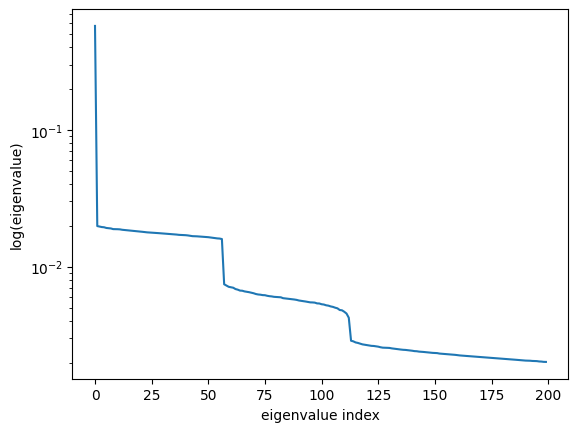

In [24]:
plt.plot(eigvals.detach().cpu().numpy())
plt.yscale('log')
#plt.title("Eigenvalue spectrum, per-class NTK (class(0,0)), layer 1 weights only, (p=29, n=512, α=0.7)")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")

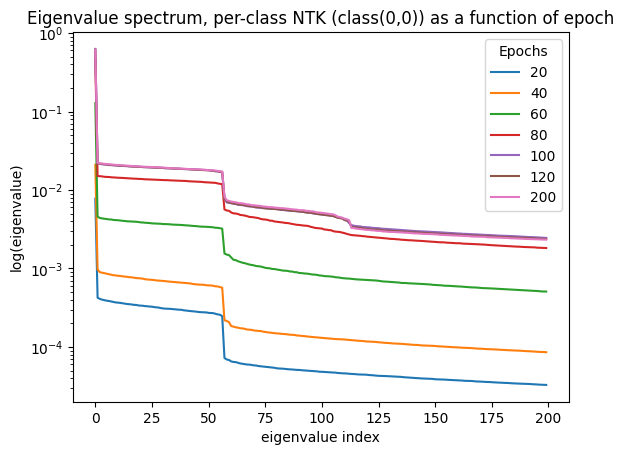

In [ ]:
plt.plot(eigvals_at_20, label = "20")
plt.plot(eigvals_at_40, label = "40")
plt.plot(eigvals_at_60, label = "60")
plt.plot(eigvals_at_80, label = "80")
plt.plot(eigvals_at_100, label = "100")
plt.plot(eigvals_at_120, label = "120")
plt.plot(eigvals_at_200, label = "200")
plt.yscale('log')
plt.title("Eigenvalue spectrum, per-class NTK (class(0,0)) as a function of epoch")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")
plt.legend(title="Epochs", loc="best", frameon=True)

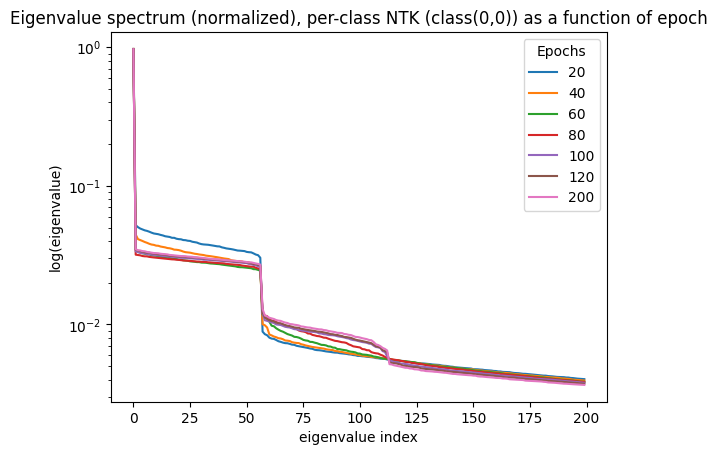

In [ ]:
plt.plot(eigvals_at_20/np.linalg.norm(eigvals_at_20), label = "20")
plt.plot(eigvals_at_40/np.linalg.norm(eigvals_at_40), label = "40")
plt.plot(eigvals_at_60/np.linalg.norm(eigvals_at_60), label = "60")
plt.plot(eigvals_at_80/np.linalg.norm(eigvals_at_80), label = "80")
plt.plot(eigvals_at_100/np.linalg.norm(eigvals_at_100), label = "100")
plt.plot(eigvals_at_120/np.linalg.norm(eigvals_at_120), label = "120")
plt.plot(eigvals_at_200/np.linalg.norm(eigvals_at_200), label = "200")
plt.yscale('log')
plt.title("Eigenvalue spectrum (normalized), per-class NTK (class(0,0)) as a function of epoch")
plt.xlabel("eigenvalue index")
plt.ylabel("log(eigenvalue)")
plt.legend(title="Epochs", loc="best", frameon=True)

In [ ]:
x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

plt.plot(x_axis, tr_acc, label="Train accuracy")
plt.plot(x_axis, te_acc, label="Test accuracy")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and test accuracy (p=29, n=512, α=0.7)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

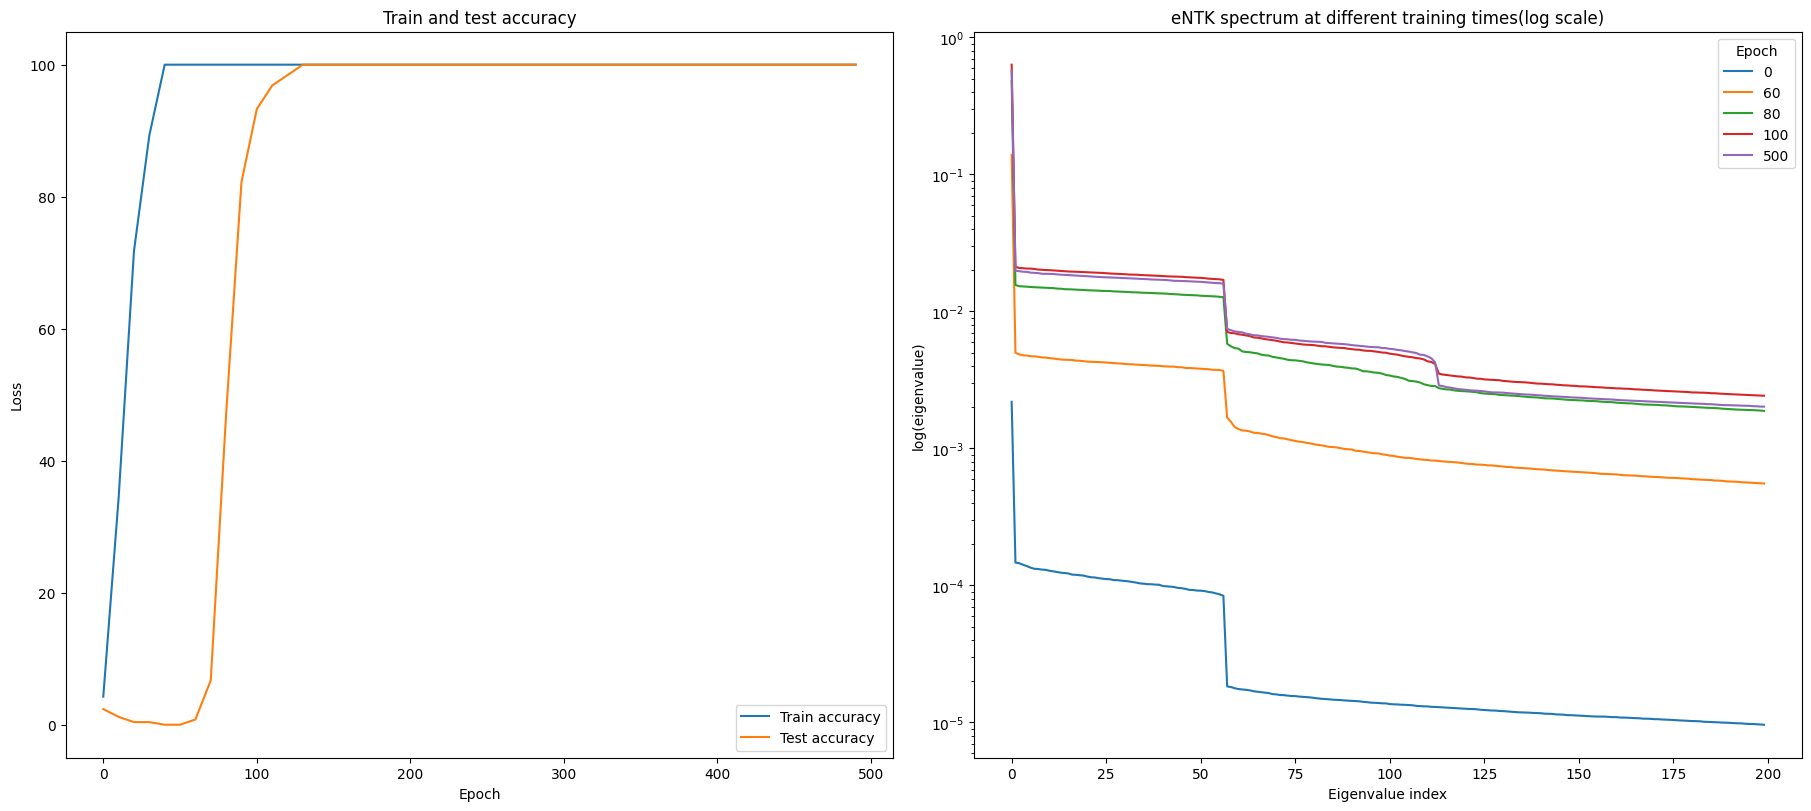

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    1,2, figsize=(18, 8),
    #sharex='col', sharey='row',
    constrained_layout=True
)

x_axis = np.arange(start=0, stop=params.epochs, step=params.log_every)

axs[0].plot(x_axis, tr_acc, label="Train accuracy")
axs[0].plot(x_axis, te_acc, label="Test accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Train and test accuracy")
axs[0].legend()
#axs[0].grid(True, alpha=0.3)
#axs[0].set_tight_layout()


axs[1].plot(eigvals_at_0, label = "0")
axs[1].plot(eigvals_at_60, label = "60")
axs[1].plot(eigvals_at_80, label = "80")
axs[1].plot(eigvals_at_100, label = "100")
#axs[1].plot(eigvals_at_120, label = "120")
axs[1].plot(eigvals_at_500, label = "500")
axs[1].set_yscale('log')
axs[1].set_title("eNTK spectrum at different training times(log scale)")
axs[1].set_xlabel("Eigenvalue index")
axs[1].set_ylabel("log(eigenvalue)")
axs[1].legend(title="Epoch", loc="best", frameon=True)

plt.show()

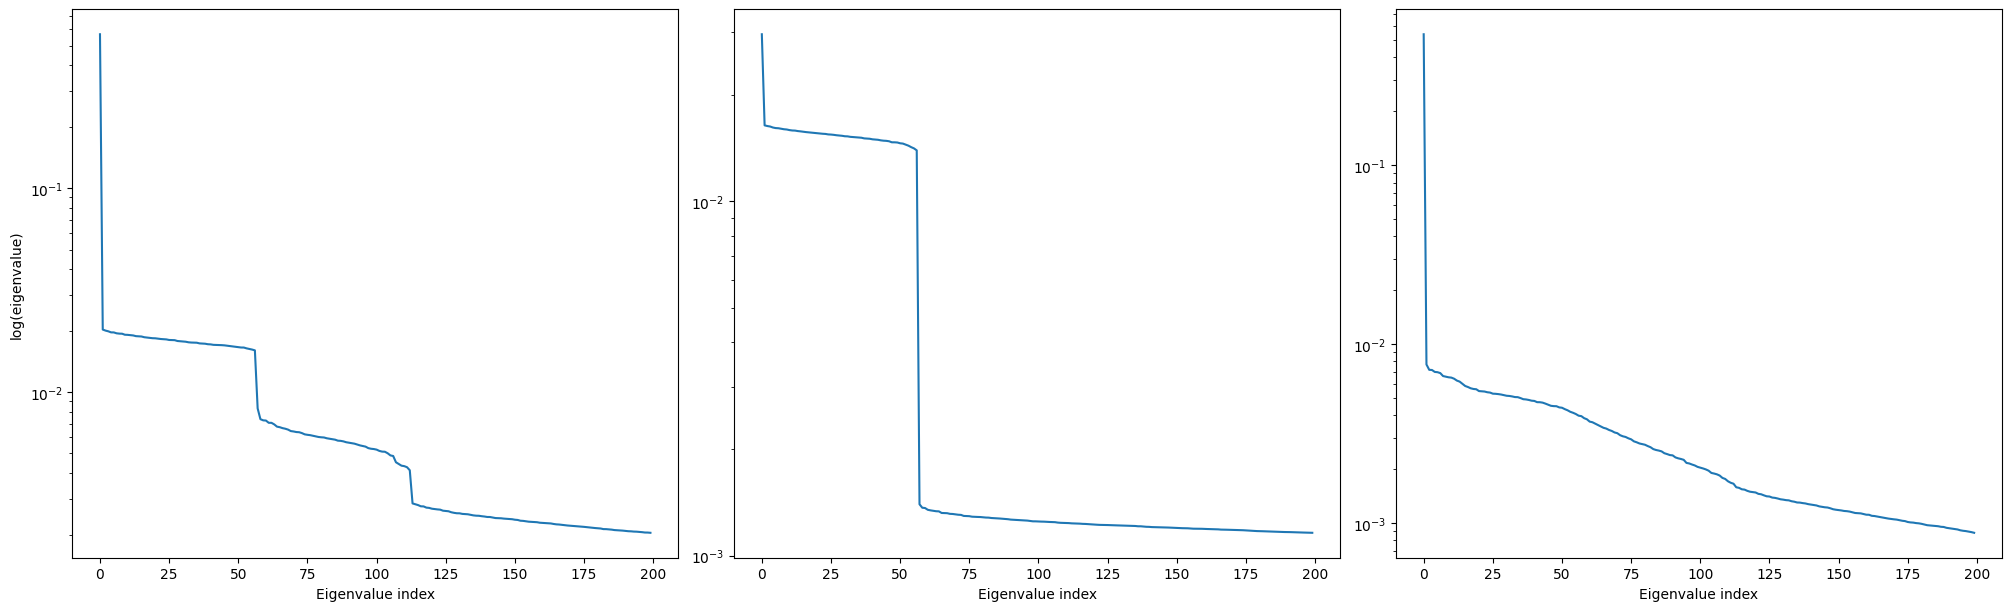

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    1,3, figsize=(20, 6),
    #sharex='col', sharey='row',
    constrained_layout=True
)

axs[0].plot(eigvals_full)
axs[0].set_yscale('log')
#axs[0].set_title("Full eNTK spectrum")
axs[0].set_xlabel("Eigenvalue index")
axs[0].set_ylabel("log(eigenvalue)")


axs[1].plot(eigvals_0)
axs[1].set_yscale('log')
#axs[1].set_title("Layer 1")
axs[1].set_xlabel("Eigenvalue index")
#axs[1].set_ylabel("log(eigenvalue)")


axs[2].plot(eigvals_3)
axs[2].set_yscale('log')
#axs[2].set_title("Layer 2")
axs[2].set_xlabel("Eigenvalue index")
#axs[1].set_ylabel("log(eigenvalue)")

plt.show()

### 2.2.3. Distentanglement

... then for **a(ny) block of eigenvectors inside one of the eigenvalue cliffs**, we can see if we can rotate them to line up with Fourier modes.

In [25]:
c1 = eigvecs[:, 1:57]  # First cliff. Shape: [841, 56]
#c1 = eigvecs[:, 57:113]  # Second cliff. Shape: [841, 56]

#### Two-stage graph smoothness

The following works to completely disentangle the first cliff of 56 Fourier modes.

In [26]:
p=29

In [27]:
@t.no_grad()
def phase_insensitive_corr(cols: t. Tensor, binary_indicators: np.ndarray) -> np.ndarray:
  """
  Inputs:
    cols: shape (N,k) t.Tensor with N = number of dataset points; k = size of eigenvalue cliff.
    binary_indicators: shape (N,K,2) pair of indicators from binary_indicator function above, with K = floor (p//2).

  Outputs:
    shape (K,k) thing that we plot in the heatmap.
  """
  A = cols / (cols.norm(dim=0, keepdim=True) + 1e-12)
  F = t.from_numpy(binary_indicators).to(A.device, A.dtype)
  F = F / (t.linalg.norm(F, dim=0, keepdim=True) + 1e-12)
  H = (F.permute(2,1,0) @ A).norm(dim=0)
  return H.cpu().numpy()

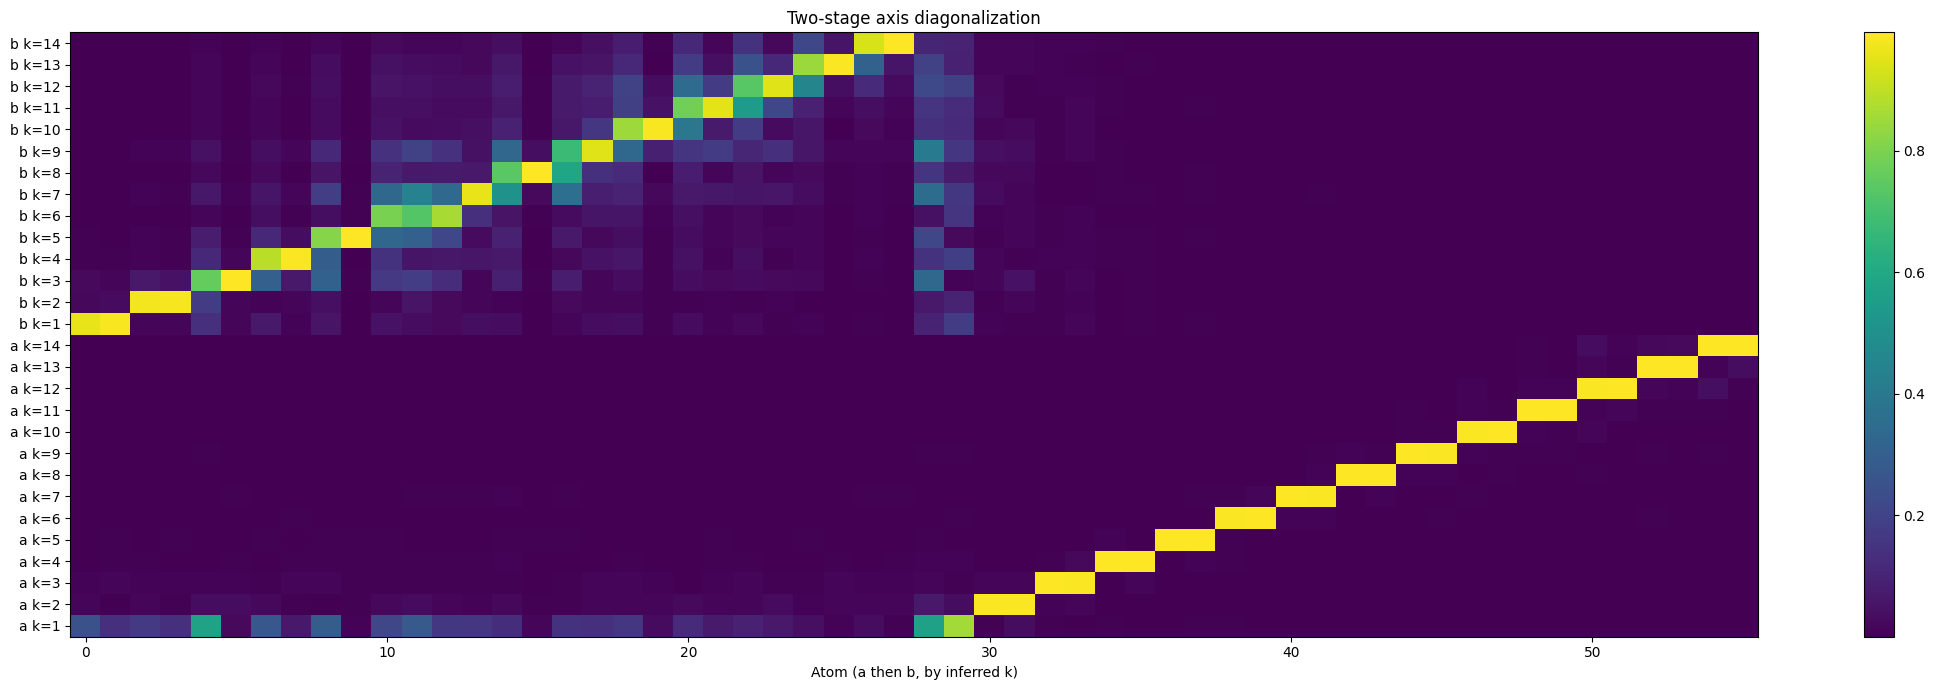

In [28]:
Ln, Lm = axis_laplacians_pxp(p)
U = two_stage_axis_diagonalization(c1, Ln.to(device), Lm.to(device))

# --- 4) Plot stacked n/m heatmaps (phase-insensitive, for evaluation) -----

Hn = phase_insensitive_corr(U, feats['n'])                 # (K,56)   # n->a, m->b   So bottom 28 modes correspond to 'b' and next to 'a'
Hm = phase_insensitive_corr(U, feats['m'])                 # (K,56)
stacked = np.vstack([Hn, Hm])

plt.figure(figsize=(22,7))
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar()
Khalf = Hn.shape[0]
yt = [f"a k={i+1}" for i in range(Khalf)] + [f"b k={i+1}" for i in range(Khalf)]
plt.yticks(range(stacked.shape[0]), yt)
plt.xlabel("Atom (a then b, by inferred k)"); plt.title("Two-stage axis diagonalization")
plt.tight_layout(); plt.show()

# Optional: quick diagnostic—axis separation
#plt.figure(figsize=(5,5))
#plt.scatter(en, em, s=20, alpha=0.8)
#plt.xlabel("Rayleigh(L_n)"); plt.ylabel("Rayleigh(L_m)")
#plt.title("Per-atom axis energies (lower=axis-invariant)")
#plt.tight_layout(); plt.show()

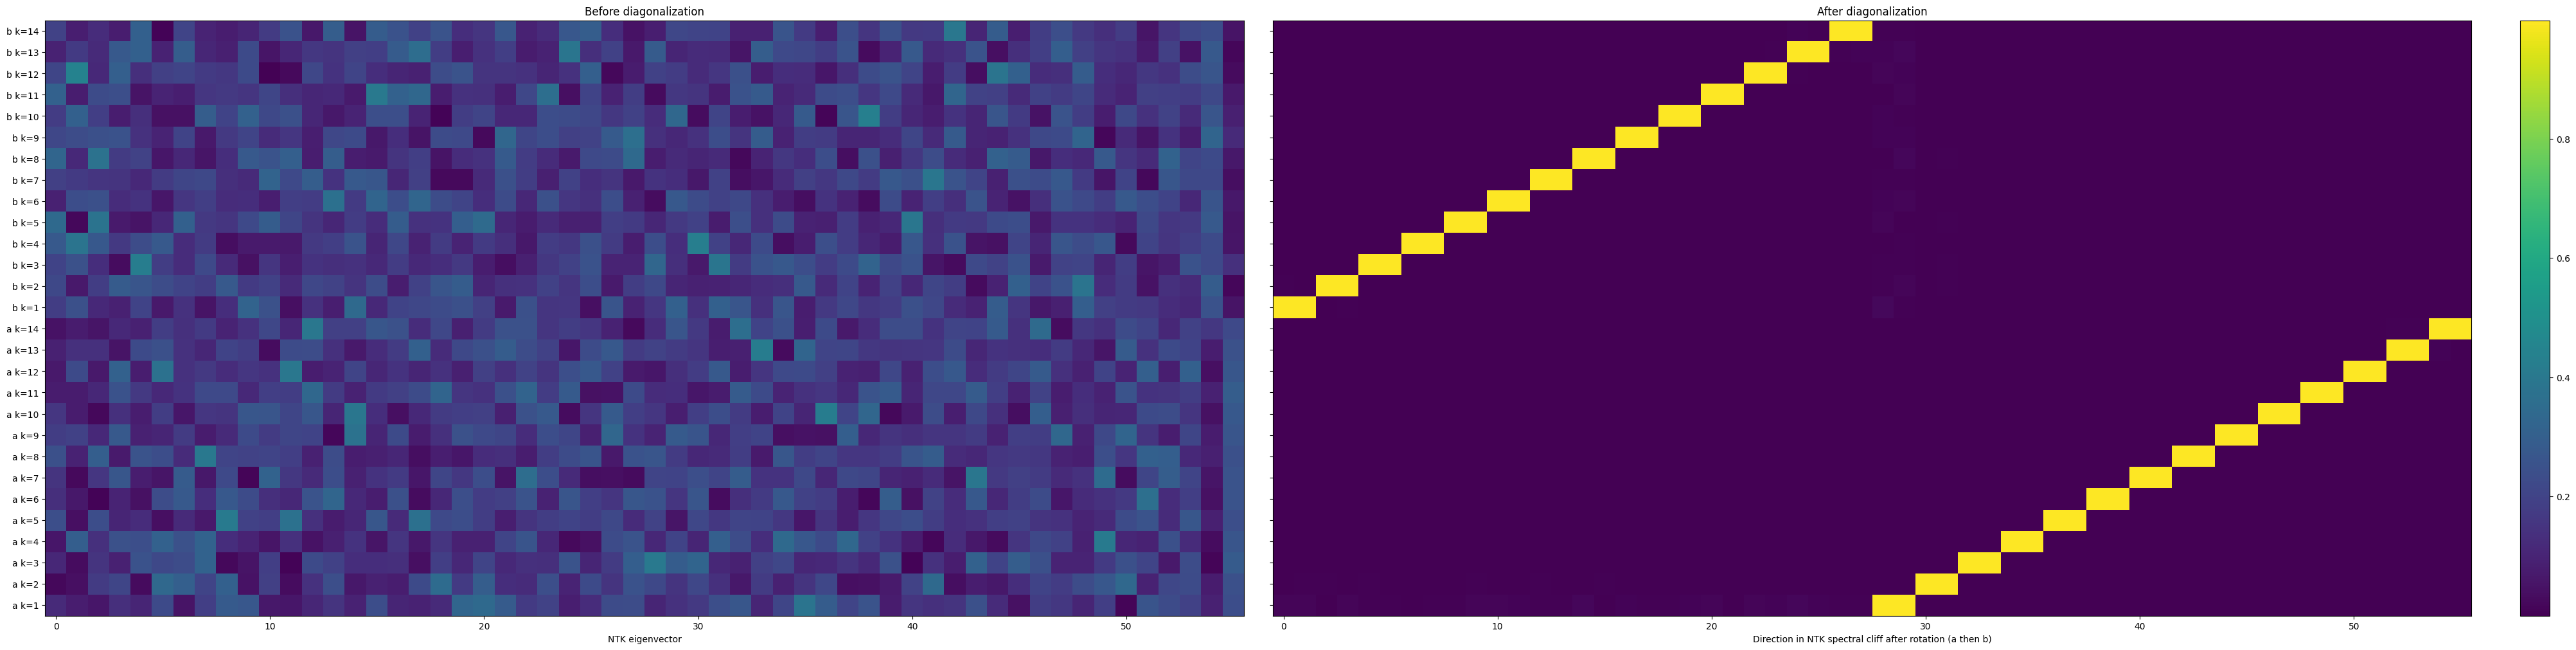

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, axs = plt.subplots(
    1, 2, figsize=(40, 10),
    sharex='col', sharey='row',
    constrained_layout=True
)

vmin = min(stacked.min(), Cstacked.min())
vmax = max(stacked.max(), Cstacked.max())
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

axs[0].imshow(Cstacked, cmap='viridis', origin='lower', aspect='auto', norm=norm)
yt = [f"a k={i+1}" for i in range(Khalf)] + [f"b k={i+1}" for i in range(Khalf)]
axs[0].set_yticks(range(stacked.shape[0]), yt)
axs[0].set_title("Before diagonalization")
axs[0].set_xlabel("NTK eigenvector")

axs[1].set_title("After diagonalization")
im = axs[1].imshow(stacked, cmap='viridis', origin='lower', aspect='auto', norm=norm)
axs[1].set_xlabel("Direction in NTK spectral cliff after rotation (a then b)")


cbar = fig.colorbar(im, ax=axs, location='right', fraction=0.025, pad=0.02)

plt.show()

In [ ]:
def sum_diff_laplacians_pxp(p: int, device=None, dtype=t.float32):
    # guard against p being a tensor
    p = int(p)
    N = p * p
    idx = t.arange(N, device=device).reshape(p, p)  # (n,m) -> linear i

    def perm_from_roll(dx, dy):
        # permutation matrix for (n,m) -> (n+dx, m+dy) mod p
        perm = idx.roll(shifts=(dx, dy), dims=(0, 1)).reshape(-1)  # target rows
        S = t.zeros((N, N), device=device, dtype=dtype)
        S[perm, t.arange(N, device=device)] = 1.0
        return S

    I_N = t.eye(N, device=device, dtype=dtype)

    # Sum direction: (+1,+1), (-1,-1)
    S_sp = perm_from_roll(+1, +1)
    S_sm = perm_from_roll(-1, -1)

    # Diff direction: (+1,-1), (-1,+1)
    S_dp = perm_from_roll(+1, -1)
    S_dm = perm_from_roll(-1, +1)

    Ls = 2 * I_N - S_sp - S_sm
    Ld = 2 * I_N - S_dp - S_dm

    ## Symmetrize & make contiguous
    #Ls = (0.5 * (Ls + Ls.T))
    #Ld = (0.5 * (Ld + Ld.T))
    return Ls, Ld

In [ ]:
def two_stage_axis_diagonalization(
    c1: t.Tensor, L1: t.Tensor, L2: t.Tensor
) -> t.Tensor:
    """
    First diagonalize L1 inside span(c1) -> sort by n-frequency.
    Then within the 0-eigenvalue eigenspace of L1, diagonalize L2 -> sort by m-frequency.

    Return U(N,k): basis of c1 (...)
    """
    N, k = c1.shape
    Q = t.linalg.qr(c1, mode="reduced")[0]

    # Diagonalize L1 inside span(c1) -> sort by n-frequency.
    An = Q.T @ L1 @ Q
    vals, vecs_n = t.linalg.eigh(An)
    Q1 = Q @ vecs_n

    o=0
    # L1 should have near-degenerate groups of eigenvalues.
    Bm = Q1[:, : k // 2 + o].T @ L2 @ Q1[:, : k // 2 +o]
    vals_m, vecs_m = t.linalg.eigh(Bm)
    Q2 = Q1[:, : k // 2+o] @ vecs_m

    return t.cat([Q2, Q1[:, k // 2 +o:]], dim=1)

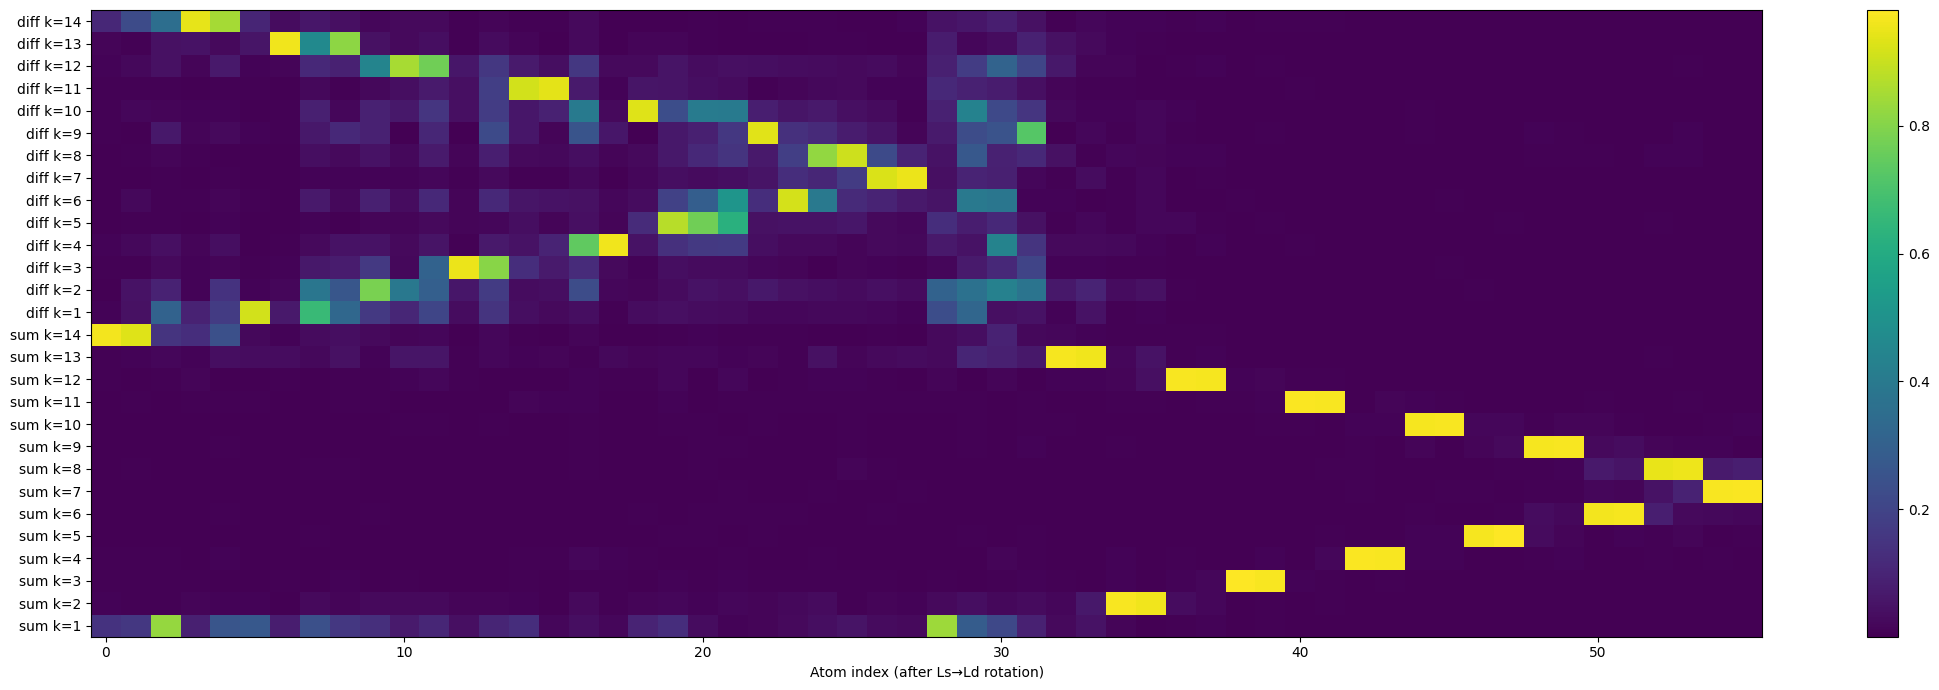

In [ ]:
# Something like the longer we train the more mixing we get ?.

Lsum, Ldiff = sum_diff_laplacians_pxp(p, device=device)
U = two_stage_axis_diagonalization(c1, Lsum.to(device), Ldiff.to(device))

# 4) Heatmaps: phase-insensitive alignment to sum/diff Fourier families
Hs = phase_insensitive_corr(U, feats['sum'])   # (K, k)
Hd = phase_insensitive_corr(U, feats['diff'])  # (K, k)
stacked = np.vstack([Hs, Hd])

# 5) Plot
plt.figure(figsize=(22, 7))
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar()
Khalf = Hs.shape[0]
yt = [f"sum k={i+1}" for i in range(Khalf)] + [f"diff k={i+1}" for i in range(Khalf)]
plt.yticks(range(stacked.shape[0]), yt)
plt.xlabel("Atom index (after Ls→Ld rotation)"); #plt.title("Layer-2 cliff: sum/diff alignment")
plt.tight_layout(); plt.show()

In [ ]:
e500 = stacked

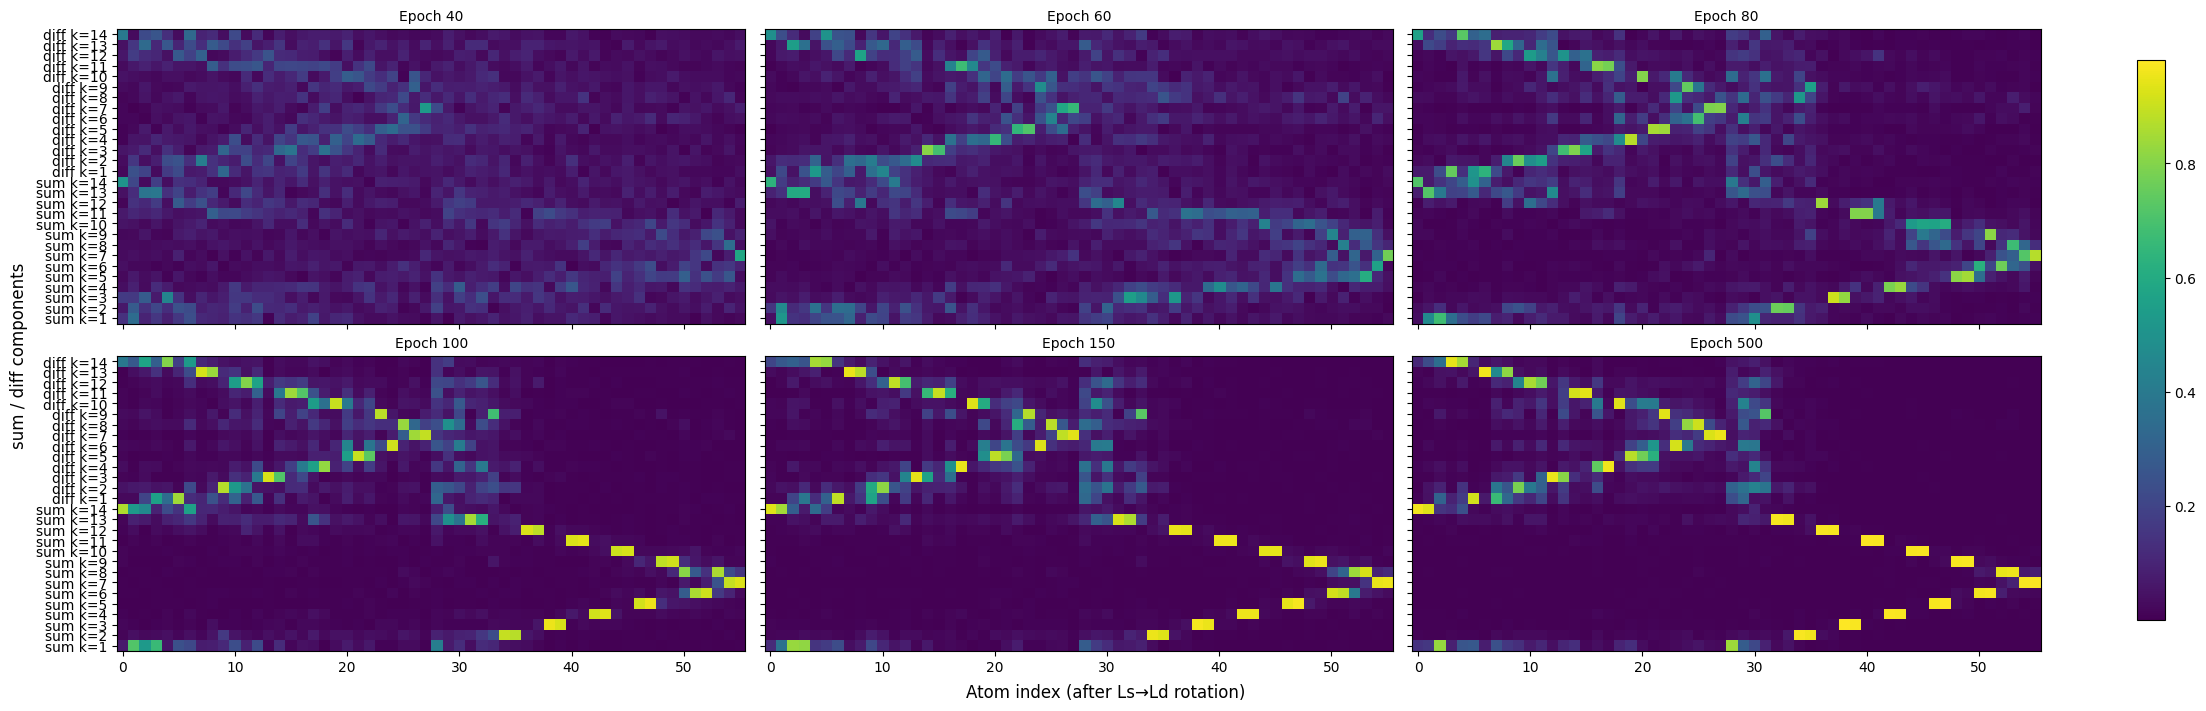

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with your six 2D arrays (all the same shape).
# If you only have one array called `stacked`, this repeats it 6 times:
#images = [e40, e70, e100, e150, e300, e500]
images = [e40, e60, e80, e100, e150, e500]

titles = ["Epoch 40", "Epoch 60", "Epoch 80", "Epoch 100", "Epoch 150", "Epoch 500"]  # or any strings you like

# Common y-ticks/labels (from your example)
Khalf = Hs.shape[0]
yt = [f"sum k={i+1}" for i in range(Khalf)] + [f"diff k={i+1}" for i in range(Khalf)]
yticks = np.arange(images[0].shape[0])

# Use shared limits so colors are comparable across subplots
vmin = min(img.min() for img in images)
vmax = max(img.max() for img in images)

fig, axes = plt.subplots(
    2, 3, figsize=(22, 7),
    sharex=True, sharey=True,
    constrained_layout=True
)

# Flatten axes for easy looping
axes = axes.ravel()

# Plot each image
mappable = None
for i, (ax, img) in enumerate(zip(axes, images)):
    im = ax.imshow(img, cmap='viridis', origin='lower', aspect='auto',
                   vmin=vmin, vmax=vmax)
    ax.set_title(titles[i], fontsize=10)  # <- per-subplot title
    mappable = im

# Put y-ticks/labels only on the left column to avoid clutter
for r in range(2):
    ax = axes[r*3 + 0]  # leftmost in each row
    ax.set_yticks(yticks)
    ax.set_yticklabels(yt)
# Hide y tick labels on the other columns (still shared)
for r in range(2):
    for c in (1, 2):
        axes[r*3 + c].tick_params(labelleft=False)

# Shared x/y labels for the whole figure
fig.supxlabel("Atom index (after Ls→Ld rotation)")
fig.supylabel("sum / diff components")

# One colorbar for all subplots
cbar = fig.colorbar(mappable, ax=axes, shrink=0.9)
# cbar.set_label("Your colorbar label")

plt.show()

In [ ]:
plt.figure(figsize=(22,7))
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.colorbar()
Khalf = Hn.shape[0]
yt = [f"n k={i+1}" for i in range(Khalf)] + [f"m k={i+1}" for i in range(Khalf)]
plt.yticks(range(stacked.shape[0]), yt)
plt.xlabel("Atom (n then m, by inferred k)"); plt.title("Two-stage axis diagonalization")
plt.tight_layout(); plt.show()


#### Scratchwork: old graph laplacian. IGNORE THIS

This was an earlier attempt that "sort of" looked like it worked but required ordering columns manually ... not necessarily much better than ordering SDL columns manually! The above approach is better and actually works

In [ ]:
def build_graph_laplacian_from_kernel(K: t.Tensor) -> t.Tensor:
  """
  Given a kernel K, return a (positive,) symmetrized version of it
  with the diagonal replaced by the negative sum over the rest of the row.
  This object is called the "combinatorial Laplacian".
  """
  device, dtype = K.device, K.dtype

  # Build a weighted adjacency matrix from the kernel
  W = K.clone()
  W.fill_diagonal_(0)
  W = t.relu(W)

  # Symmetrize
  W = 0.5 * (W + W.T)

  # Make row sums 0
  d = W.sum(dim=1)
  D = t.diag(d)
  L = D-W
  return L

In [ ]:
@t.no_grad()
def smooth_rotation(
    J: t. Tensor,                     # shape: (N,k) that we want to rotate
    L_graph: t.Tensor                 # shape: (N,N)
) -> tuple[t.Tensor, t.Tensor]:
  """
  Rotate J to line up with the smoothest directions in L_graph.

  Returns:
    A: (N,k) smooth orthonormal basis in sample space (atoms)
    S: (k,k) codes s.t. A @ S = J
  """
  N,k = J.shape
  device, dtype = J.device, J.dtype

  # Orthonormalize J
  Q, R = t.linalg.qr(J, mode='reduced')  # Q is the orthonormalized version of J w/(k) orthonormal columns.

  # Compute and symmetrize q^T *L * Q.
  L_sub = Q.T @ L_graph @ Q              # shape (k,N) * (N,N) * (N,k) = shape (k,k)
  L_sub = 0.5 * (L_sub + L_sub.T)

  eigvals, eigvecs = t.linalg.eigh(L_sub)# ascending

  A = Q @ eigvecs                        # shape (N,k)* (k,k) = shape (N,k).
  S = eigvecs.T @ R

  return A,S

In [ ]:
L = build_graph_laplacian_from_kernel(entk_0[:,:,0,0])
A,S = smooth_rotation(c1, L_graph=L)

In [ ]:
def phase_corr(A, F):
  """
  Inputs:
    A: (N,k)    atoms from above
    F: (N,k,2)  sin/cos atoms from binary indicator fn.
  Normalize A, F and return the normalized correlation matrix
  of A with each Fourier family (norm over sin + cos at a given frequency)
  """
  #A = t.from_numpy(A)
  F = t.from_numpy(F).to(device)
  A = A / (1e-12 + t.linalg.norm(A, dim=0))
  F = F / (1e-12 + t.linalg.norm(F, dim=0))
  H = (F.permute(2,1,0) @ A).norm(dim=0) # (k,k)
  return H

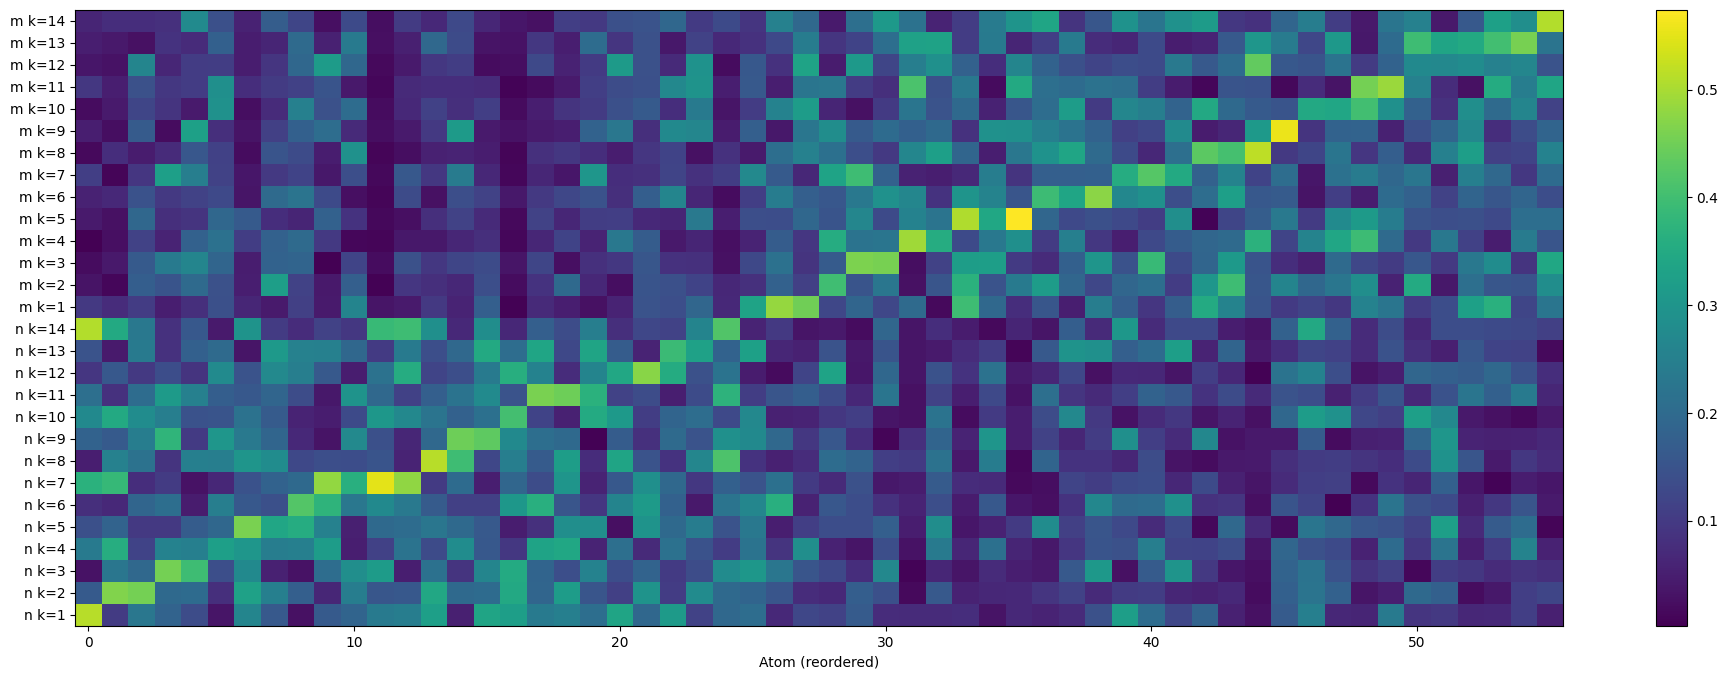

In [ ]:
F_n = t.from_numpy(feats['n']).float().to(A.device)   # (N,K,2)
F_m = t.from_numpy(feats['m']).float().to(A.device)   # (N,K,2)

Hn = phase_corr(A, feats['n'])  # (K,k)
Hm = phase_corr(A, feats['m'])  # (K,k)

# For each of the k columns, report whether its strongest correlation with anything is in 'm' or 'n'.
best_is_n = (Hn.max(dim=0).values >= Hm.max(dim=0).values)  # (k,)

# For each of the k columns, return the corresponding index among whichever of 'm' or 'n' features where the correlation is strongest.
best_k = t.where(best_is_n, Hn.argmax(dim=0), Hm.argmax(dim=0))  # (k,)

# =================

# reorder atoms: first all n-atoms by frequency, then m-atoms by frequency
idx_n = t.nonzero(best_is_n, as_tuple=True)[0]
idx_m = t.nonzero(~best_is_n, as_tuple=True)[0]
order_n = idx_n[best_k[idx_n].argsort()]
order_m = idx_m[best_k[idx_m].argsort()]
order = t.cat([order_n, order_m], dim=0)

A_ord = A[:, order]
Hn_ord = Hn[:, order].cpu().numpy()
Hm_ord = Hm[:, order].cpu().numpy()

#Hn_ord = Hn.cpu().numpy()
#Hm_ord = Hm.cpu().numpy()


# visualize stacked (n on top, m below)
import matplotlib.pyplot as plt
plt.figure(figsize=(24,8))
stacked = np.vstack([Hn_ord, Hm_ord])  # (2K, k)
plt.imshow(stacked, cmap='viridis', origin='lower', aspect='auto')
plt.yticks(
    list(range(stacked.shape[0])),
    [f"n k={i+1}" for i in range(Hn_ord.shape[0])] + [f"m k={i+1}" for i in range(Hm_ord.shape[0])]
)
plt.xlabel("Atom (reordered)"); plt.colorbar(); plt.show()

## 2.3 Ablation

In [32]:
layer_J = jacobian_by_layer(model.to(device), X.to(device))

In [33]:
for key in layer_J:
  print(key)

net.0
net.3


In [34]:
layer_J['net.0'].shape

torch.Size([841, 29, 29696])

In [35]:
print(layer_J['net.0'].mean(dim=1).shape)

torch.Size([841, 29696])


In [36]:
# B = product of layer 0 Jacobian (shape 841, P1 = 2*29*512).T with NTK eigendirections corresponding to feature 'a'

B_a = layer_J['net.0'].mean(dim=1).T @ U[:, 28:]     # Shape [2*29*512, 28]
B_b = layer_J['net.0'].mean(dim=1).T @ U[:, :28]

In [38]:
# Get L1 weights
@t.no_grad()
def _first_linear(module: nn.Module):
    for m in module.modules():
        if isinstance(m, nn.Linear):
            return m
    raise RuntimeError("Couldn't find first nn.Linear (layer 1).")

L1 = _first_linear(model)
W1 = L1.weight

In [39]:
@t.no_grad()
def hidden_acts_from_W1(model, X):
  """
  Returns the model's activations from the first layer on inputs X.
  """
  L1 = _first_linear(model)
  # assuming architecture: logits = W2( (W1 x)^2 ), no biases
  W1 = L1.weight
  h = (X @ W1.t())**2
  return h

In [40]:
# Train linear probes to predict 'a' and 'b' before ablation
h_before = hidden_acts_from_W1(model.to(device), X.to(device))

probe_a = nn.Linear(h_before.shape[1], p, bias=True).to(device) # Move probe to the same device as h_before
opt = t.optim.Adam(probe_a.parameters(), lr=1e-2)
for _ in range(300):
    opt.zero_grad()
    loss = nn.CrossEntropyLoss()(probe_a(h_before), pairs[:,0].to(device))
    loss.backward(); opt.step()

probe_b = nn.Linear(h_before.shape[1], p, bias=True).to(device) # Move probe to the same device as h_before
opt = t.optim.Adam(probe_b.parameters(), lr=1e-2)
for _ in range(300):
    opt.zero_grad()
    loss = nn.CrossEntropyLoss()(probe_b(h_before), pairs[:,1].to(device))
    loss.backward(); opt.step()

with t.no_grad():
  acc_a_before = (probe_a(h_before).argmax(-1) == pairs[:,0].to(device)).float().mean().item()
  acc_b_before = (probe_b(h_before).argmax(-1) == pairs[:,1].to(device)).float().mean().item()

print(acc_a_before, acc_b_before)

1.0 1.0


In [41]:
# Ablate 'a' family:

# Make a copy of the model
import copy
abl_model_a = copy.deepcopy(model).eval()
abl_l1_a = _first_linear(abl_model_a)
abl_w1_a = abl_l1_a.weight

theta = abl_w1_a.detach().reshape(-1)

# Exact orthogonal projector using QR (preferred numerically)
# B_a has shape [n_params, 28]
# (If you keep the normal equations, also remove the 1e2 scaling.)
QB_a, _ = t.linalg.qr(B_a, mode="reduced")          # [n_params, 28] with orthonormal columns
theta_proj = QB_a @ (QB_a.T @ theta)                # exact projection
theta_abl = (theta - theta_proj).reshape_as(abl_w1_a)

with t.no_grad():
    abl_w1_a.copy_(theta_abl)

In [42]:
frac_removed = (t.norm(theta_proj) / t.norm(theta)).item()
print("fraction of θ removed:", round(frac_removed, 6))

fraction of θ removed: 0.009737


In [43]:
# Ablate 'b' family
import copy
abl_model_b = copy.deepcopy(model).eval()
abl_l1_b = _first_linear(abl_model_b)
abl_w1_b = abl_l1_b.weight

theta = abl_w1_b.detach().reshape(-1)

QB_b, _ = t.linalg.qr(B_b, mode="reduced")
theta_proj = QB_b @ (QB_b.T @ theta)
theta_abl = (theta - theta_proj).reshape_as(abl_w1_b)

with t.no_grad():
    abl_w1_b.copy_(theta_abl)

In [44]:
frac_removed = (t.norm(theta_proj) / t.norm(theta)).item()
print("fraction of θ removed:", round(frac_removed, 6))

fraction of θ removed: 0.009712


In [45]:
h_after = hidden_acts_from_W1(abl_model_a, X)
with t.no_grad():
    acc_a = (probe_a(h_after).argmax(-1) == pairs[:,0].to(device)).float().mean().item()
    acc_b = (probe_b(h_after).argmax(-1) == pairs[:,1].to(device)).float().mean().item()
print("After ablate a: acc_a, acc_b =", acc_a, acc_b)

# After ablating 'b'
h_after = hidden_acts_from_W1(abl_model_b, X)
with t.no_grad():
    acc_a = (probe_a(h_after).argmax(-1) == pairs[:,0].to(device)).float().mean().item()
    acc_b = (probe_b(h_after).argmax(-1) == pairs[:,1].to(device)).float().mean().item()
print("After ablate b: acc_a, acc_b =", acc_a, acc_b)

After ablate a: acc_a, acc_b = 1.0 1.0
After ablate b: acc_a, acc_b = 1.0 1.0


Removing this projection doesn't seem to change how the previously trained linear probe computes a or b.
[NB: If I remove 100* the projected direction it does change the accuracy a lot for both probes, but not sure this is meaningful.]

In [46]:
# ======== Previously: We can train a brand new linear probe on the ablated model but we'd expect it to do even better ========

def train_linear_probe(h, y, num_classes, steps=300, lr=1e-2):
    probe = nn.Linear(h.shape[1], num_classes, bias=True).to(h.device) # Move probe to the same device as h
    opt = t.optim.Adam(probe.parameters(), lr=lr)
    for _ in range(steps):
        logits = probe(h)
        loss = nn.CrossEntropyLoss()(logits, y.to(h.device)) # Move y to the same device as h
        opt.zero_grad(); loss.backward(); opt.step()
    with t.no_grad():
        acc = (probe(h).argmax(-1) == y.to(h.device)).float().mean().item() # Move y to the same device as h
    return acc

In [47]:
acc_before = train_linear_probe(hidden_acts_from_W1(model.to(device), X.to(device)), pairs[:,0].to(device), num_classes=p)

In [48]:
acc_after = train_linear_probe(hidden_acts_from_W1(abl_model_a.to(device), X.to(device)), pairs[:,0].to(device), num_classes=p)
acc_after

1.0